# モデルを学習するnotebook

In [1]:
import pandas as pd
from math import sqrt as sqrt
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function
from torchsummary import summary
import torch.utils.data as data
import torch.optim as optim

import ast
import cv2
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
from utils.ssd_model import SSD
from utils.ssd_model import MultiBoxLoss

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, path, patience=7, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        

In [4]:
input_size = 300
color_mean = (0, 0)
voc_classes = ['ring']

In [5]:
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': input_size,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ   
#     'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

In [6]:
# 学習データの読み込み
# 学習データはまだ上げていないです。
label = pd.read_csv('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/augmentation_for_ssd_label.csv')
data = np.load('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/augmentation_for_ssd.npy')
data = data[:,:,:,:2]
data = np.swapaxes(data, 2, 3)
data = np.swapaxes(data, 1, 2)

In [8]:
print(len(label))
print(data.shape)

10910
(10910, 2, 300, 300)


In [9]:
label = label.drop('Unnamed: 0', axis=1)
# label = label.drop('index', axis=1)
label

,fits,name,xmin,xmax,ymin,ymax,id
0,spitzer_00300+0000_rgb,['2G0020120-0068213'],[0.1365964173721316],[0.23625005149378678],[0.5551416764976318],[0.6547953106192858],0
1,spitzer_00300+0000_rgb,['2G0020120-0068213'],[0.2680902043345587],[0.5759350668725902],[0.11622007366783164],[0.42406493620585944],1
2,spitzer_00300+0000_rgb,['2G0020120-0068213'],[0.20913421224965428],[0.7757558768455542],[0.17891439044007815],[0.7455360550359712],2
3,spitzer_00300+0000_rgb,['2G0020120-0068213'],[0.0013299567596892655],[0.8233135459636813],[0.13284732971717245],[0.9548309189211464],3
4,spitzer_00300+0000_rgb,['2G0020120-0068213'],[0.0362237721148361],[0.11609338729111267],[0.07988582797457988],[0.15975544315085544],4
...,...,...,...,...,...,...,...
10905,spitzer_35700+0000_rgb,"['2G3563404-0009054', '2G3562769-0007904']","[0.2451006239665258, 0.5459186474259973]","[0.3225072113401268, 0.7007318221731992]","[0.45632328754134577, 0.47901142698633115]","[0.5337298749149418, 0.6338246017335217]",10905
10906,spitzer_35700+0000_rgb,"['2G3579667-0016881', '2G3579868-0015789', '2G...","[0.6169360219919319, 0.4533268855395715, 0.303...","[0.6946688673583395, 0.5606722436887062, 0.491...","[0.7791167239108852, 0.8450045666568464, 0.750...","[0.8568495692769483, 0.9523499248059714, 0.939...",10906
10907,spitzer_35700+0000_rgb,"['2G3558423-0048948', '2G3558804-0052267']","[0.4062549266650938, 0.027078547797243238]","[0.5988846380979796, 0.4630299925664748]","[0.7005793951317584, 0.3545218091713647]","[0.8932091065648169, 0.7904732539407884]",10907
10908,spitzer_35700+0000_rgb,"['2G3558423-0048948', '2G3558804-0052267']","[0.40473551847200395, 0.11204213937229014]","[0.5534300160634377, 0.4485612597718746]","[0.3143074011994009, 0.04717904130453973]","[0.463001898790974, 0.3836981617042862]",10908


In [10]:
# pandasのデータにlistが入っていると、listが文字列になってしまうため、これを実施
label['xmin'] = [ast.literal_eval(d) for d in label['xmin']]
label['xmax'] = [ast.literal_eval(d) for d in label['xmax']]
label['ymin'] = [ast.literal_eval(d) for d in label['ymin']]
label['ymax'] = [ast.literal_eval(d) for d in label['ymax']]

In [11]:
#  [[xmin1, ymin1, xmax1, ymax1, label1],  [xmin2, ymin2, xmax2, ymax2, label2], ・・・・・・・・・・・]と一つの画像に対するannotationを作る。
label_list = []
for i in range(len(label)):
    lab = []
    for k in range(len(label['xmin'][i])):
        labe = []
        labe.append(label['xmin'][i][k])
        labe.append(label['ymin'][i][k])
        labe.append(label['xmax'][i][k])
        labe.append(label['ymax'][i][k])
        labe.append(0)
        lab.append(labe)
    label_list.append(np.array(lab))

# for i in range(2000):
#     label_list.append(np.array([])[:,None])

In [12]:
# 一つの画像に二つのbubbleもあれば、一つのbubbleもある。
label_list[1].shape, label_list[-1].shape

((1, 5), (2, 5))

In [13]:
kf = KFold(n_splits=2, shuffle=True)
train_data_list = []
train_label_list = []
test_data_list = []
test_label_list = []
for train_index, test_index in kf.split(data, label_list):
    train_data_list.append(data[train_index])
    train_label_list.append([label_list[k] for k in train_index])
    test_data_list.append(data[test_index])
    test_label_list.append([label_list[k] for k in test_index])

In [14]:
print(len(train_data_list[0]), len(train_label_list[0]), len(test_data_list[0]), len(test_label_list[0]))

5455 5455 5455 5455


In [15]:
train_data_list[0].shape

(5455, 2, 300, 300)

In [16]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    imgs = torch.stack(imgs, dim=0)
        
    return imgs, targets

In [18]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [19]:
batch_size = 32

In [20]:
train_dataset = DataSet(torch.Tensor(train_data_list[0]), train_label_list[0])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

test_dataset = DataSet(torch.Tensor(test_data_list[0]), test_label_list[0])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

In [21]:
dataloaders_dict = {"train": train_loader, "val": test_loader}

In [22]:
#転移学習している。
# ネットにあるパラメーターを読み込む
net = SSD(phase='train', cfg=ssd_cfg)
CNN_weight = torch.load('ssd300_mAP_77.43_v2.pth')

In [23]:
net.vgg[0].weight = nn.Parameter(CNN_weight['vgg.0.weight'][:,:2,:,:])#.detach().numpy().copy()
net.vgg[0].bias = nn.Parameter(CNN_weight['vgg.0.bias'])
net.vgg[2].weight = nn.Parameter(CNN_weight['vgg.2.weight'])
net.vgg[2].bias = nn.Parameter(CNN_weight['vgg.2.bias'])
net.vgg[5].weight = nn.Parameter(CNN_weight['vgg.5.weight'])
net.vgg[5].bias = nn.Parameter(CNN_weight['vgg.5.bias'])
net.vgg[7].weight = nn.Parameter(CNN_weight['vgg.7.weight'])
net.vgg[7].bias = nn.Parameter(CNN_weight['vgg.7.bias'])
net.vgg[10].weight = nn.Parameter(CNN_weight['vgg.10.weight'])
net.vgg[10].bias = nn.Parameter(CNN_weight['vgg.10.bias'])
net.vgg[12].weight = nn.Parameter(CNN_weight['vgg.12.weight'])
net.vgg[12].bias = nn.Parameter(CNN_weight['vgg.12.bias'])
net.vgg[14].weight = nn.Parameter(CNN_weight['vgg.14.weight'])
net.vgg[14].bias = nn.Parameter(CNN_weight['vgg.14.bias'])
net.vgg[17].weight = nn.Parameter(CNN_weight['vgg.17.weight'])
net.vgg[17].bias = nn.Parameter(CNN_weight['vgg.17.bias'])
net.vgg[19].weight = nn.Parameter(CNN_weight['vgg.19.weight'])
net.vgg[19].bias = nn.Parameter(CNN_weight['vgg.19.bias'])
net.vgg[21].weight = nn.Parameter(CNN_weight['vgg.21.weight'])
net.vgg[21].bias = nn.Parameter(CNN_weight['vgg.21.bias'])
net.vgg[24].weight = nn.Parameter(CNN_weight['vgg.24.weight'])
net.vgg[24].bias = nn.Parameter(CNN_weight['vgg.24.bias'])
net.vgg[26].weight = nn.Parameter(CNN_weight['vgg.26.weight'])
net.vgg[26].bias = nn.Parameter(CNN_weight['vgg.26.bias'])
net.vgg[28].weight = nn.Parameter(CNN_weight['vgg.28.weight'])
net.vgg[28].bias = nn.Parameter(CNN_weight['vgg.28.bias'])
net.vgg[31].weight = nn.Parameter(CNN_weight['vgg.31.weight'])
net.vgg[31].bias = nn.Parameter(CNN_weight['vgg.31.bias'])
net.vgg[33].weight = nn.Parameter(CNN_weight['vgg.33.weight'])
net.vgg[33].bias = nn.Parameter(CNN_weight['vgg.33.bias'])

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [25]:
summary(net, (2, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,216
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [26]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [27]:
# net.vgg.apply(weights_init)
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

ModuleList(
  (0): Conv2d(512, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
)

In [28]:
# for i in net.parameters():
#     print(i.requires_grad)

<function matplotlib.pyplot.show(close=None, block=None)>

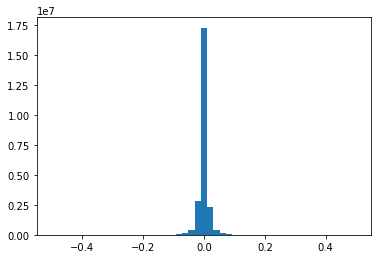

In [29]:
list_ = []
for i in net.parameters():
    i = i.to('cpu').detach().numpy().ravel()
    list_.append(i)
    pass

list_ = np.concatenate(list_)
plt.hist(list_, bins=np.linspace(-0.5, 0.5, 50))
plt.show

In [30]:
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [31]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, file_name):
    
    pos_tempo_list = []
    neg_tempo_list = []
    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    early_stopping = EarlyStopping(patience=20, verbose=True, path='weights/%s/earlystopping.pth'%(file_name))
    # イテレーションカウンタをセット
    logs = []

    # epochのループ
    for epoch in range(num_epochs):
        iteration = 0
        val_iter = 0
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                net.eval()

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device, dtype=torch.float)
                targets = [ann.to(device, dtype=torch.float) for ann in targets]  # リストの各要素のテンソルをGPUへ
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)
                    # 損失の計算
                    loss_l, loss_c, pos_mask, neg_mask = criterion(outputs, targets)
                    loss = loss_l + loss_c
                    pos_tempo_list.append(pos_mask.to('cpu'))
                    neg_tempo_list.append(neg_mask.to('cpu'))
#                     print(loss)
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                
                        loss.backward()  # 勾配の計算
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)# 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める

                        optimizer.step()  # パラメータ更新
                        epoch_train_loss += loss.item()
                        print("\r"+str(iteration)+'/'+str(int(train_data_list[0].shape[0]/batch_size))+'       ', end="")
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()
                        val_iter += 1              
        avg_train_loss = epoch_train_loss / iteration
        avg_val_loss = epoch_val_loss / val_iter
        
        print('\nepoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f} '.format(epoch+1,
                                                                                  avg_train_loss,
                                                                                  avg_val_loss))
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': avg_train_loss, 'val_loss': avg_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("weights/%s/log_output.csv"%(file_name))
        
        early_stopping(epoch_val_loss, net)
    
        if early_stopping.early_stop:
            print('Early_Stopping')
            break
            
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/%s/ssd300_'%(file_name) +
                       str(epoch+1) + '.pth')
    return torch.cat(pos_tempo_list), torch.cat(neg_tempo_list)

In [32]:
num_epoch = 300
pd_frame = pd.DataFrame(columns=['iteration', 'phase', 'loss'])
pos_tensor, neg_tensor = train_model(net,dataloaders_dict , criterion, optimizer, 
                      num_epochs=num_epoch, file_name='weights_ring_select_8_9')

使用デバイス： cuda:0
-------------
Epoch 1/300
-------------
（train）
170/170       
epoch 1 || Epoch_TRAIN_Loss:6.0020 ||Epoch_VAL_Loss:6.7604 
timer:  100.6710 sec.
Validation loss decreased (inf --> 1156.024933).  Saving model ...
-------------
Epoch 2/300
-------------
（train）
170/170       
epoch 2 || Epoch_TRAIN_Loss:5.5972 ||Epoch_VAL_Loss:7.8265 
timer:  97.0522 sec.
EarlyStopping counter: 1 out of 20
-------------
Epoch 3/300
-------------
（train）
170/170       
epoch 3 || Epoch_TRAIN_Loss:6.0363 ||Epoch_VAL_Loss:5.8270 
timer:  97.1102 sec.
Validation loss decreased (1156.024933 --> 996.419407).  Saving model ...
-------------
Epoch 4/300
-------------
（train）
170/170       
epoch 4 || Epoch_TRAIN_Loss:5.6471 ||Epoch_VAL_Loss:6.0597 
timer:  97.4283 sec.
EarlyStopping counter: 1 out of 20
-------------
Epoch 5/300
-------------
（train）
170/170       
epoch 5 || Epoch_TRAIN_Loss:4.9955 ||Epoch_VAL_Loss:5.7174 
timer:  97.3624 sec.
Validation loss decreased (996.419407 --> 977.682511)

In [37]:
torch.sum(pos_tensor, axis=0)

tensor([     0,      0,      0,  ..., 187110, 261954, 262062])

In [40]:
np.save('pos_ft.npy', pos_tensor.detach().numpy())

In [41]:
np.save('neg_ft.npy', neg_tensor.detach().numpy())

In [32]:
num_epoch = 300
pd_frame = pd.DataFrame(columns=['iteration', 'phase', 'loss'])
pd_loss = train_model(net,dataloaders_dict , criterion, optimizer, 
                      num_epochs=num_epoch, file_name='weights_ring_select_7_19_many')

使用デバイス： cuda:0
-------------
Epoch 1/300
-------------
（train）
365/366       
epoch 1 || Epoch_TRAIN_Loss:4.7217 ||Epoch_VAL_Loss:3.4005 
timer:  211.2438 sec.
Validation loss decreased (inf --> 1247.973526).  Saving model ...
-------------
Epoch 2/300
-------------
（train）
365/366       
epoch 2 || Epoch_TRAIN_Loss:2.7384 ||Epoch_VAL_Loss:2.4235 
timer:  209.0006 sec.
Validation loss decreased (1247.973526 --> 889.441406).  Saving model ...
-------------
Epoch 3/300
-------------
（train）
365/366       
epoch 3 || Epoch_TRAIN_Loss:2.2247 ||Epoch_VAL_Loss:2.2456 
timer:  209.0956 sec.
Validation loss decreased (889.441406 --> 824.137323).  Saving model ...
-------------
Epoch 4/300
-------------
（train）
365/366       
epoch 4 || Epoch_TRAIN_Loss:2.0290 ||Epoch_VAL_Loss:1.9543 
timer:  209.0663 sec.
Validation loss decreased (824.137323 --> 717.237922).  Saving model ...
-------------
Epoch 5/300
-------------
（train）
365/366       
epoch 5 || Epoch_TRAIN_Loss:1.8748 ||Epoch_VAL_Loss:1.8

In [32]:
num_epoch = 300
pd_frame = pd.DataFrame(columns=['iteration', 'phase', 'loss'])
pd_loss = train_model(net,dataloaders_dict , criterion, optimizer, 
                      num_epochs=num_epoch, file_name='weights_ring_select_7_19')

使用デバイス： cuda:0
-------------
Epoch 1/300
-------------
（train）
216/216       
epoch 1 || Epoch_TRAIN_Loss:5.7528 ||Epoch_VAL_Loss:4.6964 
timer:  126.8080 sec.
Validation loss decreased (inf --> 1019.111875).  Saving model ...
-------------
Epoch 2/300
-------------
（train）
216/216       
epoch 2 || Epoch_TRAIN_Loss:5.3458 ||Epoch_VAL_Loss:4.3489 
timer:  123.1372 sec.
Validation loss decreased (1019.111875 --> 943.708829).  Saving model ...
-------------
Epoch 3/300
-------------
（train）
216/216       
epoch 3 || Epoch_TRAIN_Loss:4.5952 ||Epoch_VAL_Loss:3.3714 
timer:  123.4019 sec.
Validation loss decreased (943.708829 --> 731.601516).  Saving model ...
-------------
Epoch 4/300
-------------
（train）
216/216       
epoch 4 || Epoch_TRAIN_Loss:2.9750 ||Epoch_VAL_Loss:3.8516 
timer:  123.5846 sec.
EarlyStopping counter: 1 out of 20
-------------
Epoch 5/300
-------------
（train）
216/216       
epoch 5 || Epoch_TRAIN_Loss:3.2476 ||Epoch_VAL_Loss:2.4431 
timer:  123.5604 sec.
Validation 